In [1]:
#! python3

import numpy as np
import sympy
import matplotlib.pyplot as plt

np.random.seed(42)

# Data

In [2]:
CRITICAL_GAP = 4.5
N = 206

distances = np.random.uniform(100, 201, size=N)
speeds = np.random.uniform(10, 31, size=N)


In [3]:
def rand(tau):
    if tau > CRITICAL_GAP + 2:
        return 1
    elif CRITICAL_GAP - 0.2 <= tau <= CRITICAL_GAP:
        return np.random.randint(0, 2)
    else:
        return 0

In [4]:
gaps = np.array([distance/speed for distance, speed in zip(distances, speeds)])
gap_acceptances = [rand(tau) for tau in gaps]

gap_data = dict(sorted(zip(gaps, gap_acceptances)))

x_data = np.array(list(gap_data.keys())).reshape(-1, 1)
y_data = np.array(list(gap_data.values()))

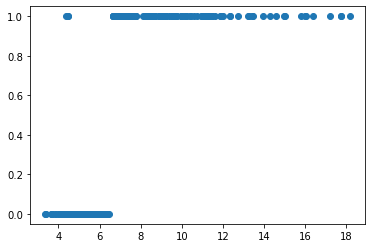

In [5]:
plt.scatter(x_data, y_data)

# Model
### $$\eta_i = \beta_1 + \beta_2 X_i$$
### $$\mu_i = E[Y_i] = \eta_i = \beta_1 + \beta_2 X_i$$


In [6]:
import numpy as np
import sympy
from scipy.stats import chi2, norm
from statistics import mean, variance
import matplotlib.pyplot as plt

np.random.seed(42)


class CustomLogit:
    def __init__(self, x, y):
        
        self.x = np.array(x)
        self.y = np.array(y)
        
        self.N = len(y)
        self.p = self.x.shape[1]
        
        self.beta_vect = np.array([sympy.Symbol(f'β{i}') for i in range(self.p)])  
        
        self.eta = np.array([xi.transpose().dot(self.beta_vect) for xi in self.x])
        self.pi = np.array([sympy.exp(n)/(1 + sympy.exp(n)) for n in self.eta])
        self.mu = self.pi.copy()
        self.xij = np.array([[sympy.diff(n, beta) for beta in self.beta_vect] 
                             for n in self.eta])
        self.__solved_betas = []
        self.__cov_matrix = []
        self.__design_matrix = []
        
    def log_likelihood(self, j):
        return sum((self.y[i] - self.mu[i])*self.xij[i][j] for i in range(self.N))
    
    @property
    def coeffs(self):
        if self.__solved_betas:
            return self.__solved_betas
        else:
            raise Exception("Model is not fitted yet.")
    
    def fit(self, initial_guess):
        ll_eqs = [self.log_likelihood(j) for j, _ in enumerate(self.beta_vect)]
        soln = sympy.nsolve(ll_eqs, self.beta_vect.flatten(), initial_guess)
        self.__solved_betas = {b: bb for b, bb in zip(self.beta_vect.flatten(), soln)}
        
    def predict(self, x):
        """Returns predictions for new x data"""
        x = np.array(x)
        etas = np.array([xi.transpose().dot(self.beta_vect).subs(self.__solved_betas) for xi in x])
        return np.array([sympy.exp(n)/(1 + sympy.exp(n)) for n in etas])
        
    @property
    def goodness_of_fit(self):
        df = self.N - self.p
        chi2crit = chi2.ppf(0.95, df)
        mu_hat = self.predict(self.x)
        deviance_statistic = 2 * sum((- (self.y[i]-mu_hat[i])) 
                                     + (self.y[i] * np.log(float(self.y[i]/mu_hat[i]))
                                        if self.y[i] > 0 else 0) 
                                     for i in range(self.N))
        return (deviance_statistic, chi2crit, df)
    
    @property
    def pearson_residuals(self):
        y_hat = self.predict(self.x)
        r = [float((self.y[i] - y_hat[i]) / y_hat[i]**0.5) for i in range(self.N)]
        self.plot(x=list(range(1, len(r)+1)), y=r, xlabel=r'$i$', ylabel=r'$r_i$', title='Pearson residuals')
        return mean(r), variance(r)
    
    def plot(self, x, y, xlabel, ylabel, title):
        fig, ax = plt.subplots()
        plt.plot(x, y, 'r')
        ax.set_xlabel(xlabel, fontsize=15)
        ax.set_ylabel(ylabel, fontsize=15)
        ax.set_title(title)
        plt.show()
        
    @property
    def W(self):
        if self.__design_matrix:
            return self.__design_matrix
        pi_hat = np.array([self.pi[i].subs(self.__solved_betas) for i in range(N)])
        return np.diag(np.array([pi_hat[i]*(1-pi_hat[i]) for i in range(self.N)]))
    
    @property
    def cov_matrix(self):
        if self.__cov_matrix:
            return self.__cov_matrix
        wx = model.W.dot(self.x)
        xtwx = np.array(self.x.transpose().dot(wx), dtype=float)
        return np.linalg.inv(xtwx)
    
    def std_error(self, i):
        return (self.cov_matrix[i][i])**0.5
    
    def z_statistic(self, i):
        return list(self.coeffs.values())[i] / self.std_error(i)
    
    def p_statistic(self, i):
        return norm.cdf(float(self.z_statistic(i)))
        

In [7]:
x = [[1, *x_i] for x_i in x_data]
y = y_data

model = CustomLogit(x, y)

In [8]:
model.fit(initial_guess=(-10, 9))

ValueError: Could not find root within given tolerance. (1.15242559769104941809e-15 > 2.16840434497100886801e-19)
Try another starting point or tweak arguments.

In [ ]:
print(model.coeffs)

In [ ]:
model.cov_matrix

In [ ]:
se = [model.std_error(i) for i, _ in enumerate(model.beta_vect)]
se

In [ ]:
z = [model.z_statistic(i) for i, _ in enumerate(model.beta_vect)]
z

In [ ]:
p = [model.p_statistic(i) for i, _ in enumerate(model.beta_vect)]
p

In [ ]:
y

In [ ]:
model.predict(x)